In [3]:
import json
import os
from transformers import AutoTokenizer
import random
# import spacy
import re
import csv
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
ROOT = '/data0/lucy/language-map-of-science/'
DATA = ROOT + 'data/'
LOGS = ROOT + 'logs/'
CLUSTER_FOLDER = LOGS + 'word_clusters_lemmed/0.0/'
INDEX_DIR = LOGS + 'inverted_index/'
SENSE_DIR = LOGS + 'sense_assignments_lemmed/'
SENSE_INPUT_DIR = DATA + 'sense_input/actual_data/'
NUM_REPS = 5

## View example clusters

You can pick a couple of words of interest and see what clusters were learned and the clusters' top representatives. 

In [5]:
tokenizer = AutoTokenizer.from_pretrained('globuslabs/ScholarBERT', use_fast=True)

Downloading: 100%|██████████| 300/300 [00:00<00:00, 205kB/s]
Downloading: 100%|██████████| 373k/373k [00:00<00:00, 2.02MB/s]
Downloading: 100%|██████████| 763k/763k [00:00<00:00, 3.01MB/s]
Downloading: 100%|██████████| 112/112 [00:00<00:00, 56.9kB/s]


In [10]:
def show_top_reps(w, sense=None, n=10, highlight=None, cluster_folder=CLUSTER_FOLDER): 
    '''
    Shows the top reps for a word. 
    If sense is not None, it only prints out the representatives for that sense. 
    n is the number of reps to show. 
    '''
    f = w + '_clustering.json'
    if not os.path.exists(os.path.join(cluster_folder, f)):
        print(w, 'NOT FOUND')
        return
    with open(os.path.join(cluster_folder, f), 'r') as infile: 
        d = json.load(infile)[str(NUM_REPS)]
    # this is already sorted by most to least common representatives
    print('WORD:', w)
    for i, clust in enumerate(d): 
        if sense and i != sense: continue
        rep_str = []
        for rep in clust: 
            rep_str.append(tokenizer.convert_ids_to_tokens(rep[0]))
        if highlight and i in highlight: 
            print("\x1b[31m" + str(i) + "\x1b[0m", rep_str[:n])
        else: 
            print(i, ', '.join(rep_str[:n]))
    print()

In [12]:
# words_of_interest = ['kernel', 'performance', 
#                      'network', 'cost', 'power', 
#                      'code', 'probability', 'rank', 'bias', 'root']
words_of_interest = ['title']
for w in words_of_interest: 
    show_top_reps(w)

WORD: title
0 bottom, cover, top, last, first, main, second, led, final, executive
1 compound, whole, model, correspond, Follow, result, new, target, structure, general
2 tail, balance, show, goal, specific, load, bias, race, tendency, pronoun
3 hing, every, one, 416, constituent, particular, excess, biochemical, ina, stagg
4 post, position, rank, degree, category, stand, office, licence, role, person
5 book, section, hand, page, end, column, chapter, part, text, description
6 prize, winner, majority, house, held, competition, election, presentation, contest, victory
7 design, theme, series, project, team, game, work, composition, plot, development
8 phrase, label, latter, address, honour



## Effects of preprocessing on cluster assignments

This section looks at how text preprocessing might impact cluster outputs. (Only manual inspection, nothing fancy.)

### Lemmatization 

Below are clusters for unlemmatized words, to investigate the impact of lemmatization. 

In [218]:
CLUSTER_FOLDER = '/home/lucyl/language-map-of-science/logs/word_clusters/'

In [219]:
vocab = set()
missing_vocab_errors = set()
with open(LOGS + 'sense_vocab/wsi_vocab_set_98_50.txt', 'r') as infile: 
    for line in infile: 
        w = line.strip()
        if not os.path.exists(CLUSTER_FOLDER + w + '_clustering.json'):
            missing_vocab_errors.add(w)
            continue
        vocab.add(w)

In [220]:
nlp = spacy.load("en_core_web_lg", disable=['ner', 'parser'])

In [221]:
simple_lemma_pairs = []
for w in vocab: 
    spacy_token = nlp(w)[0]
    if spacy_token.lemma_ in vocab and spacy_token.lemma_ != w: 
        simple_lemma_pairs.append((w, spacy_token.lemma_))

In [222]:
random.seed(30)
random.shuffle(simple_lemma_pairs)
print(simple_lemma_pairs[:10])

[('linked', 'link'), ('supported', 'support'), ('phenotypes', 'phenotype'), ('reveals', 'reveal'), ('manipulating', 'manipulate'), ('dominated', 'dominate'), ('advances', 'advance'), ('weeks', 'week'), ('started', 'start'), ('deficiencies', 'deficiency')]


In [223]:
words_of_interest = []
for pair in simple_lemma_pairs[:10]: 
    words_of_interest.append(pair[0])
    words_of_interest.append(pair[1])

In [224]:
for w in words_of_interest: 
    f = w + '_clustering.json'
    if not os.path.exists(CLUSTER_FOLDER + f):
        print(w, 'NOT FOUND')
    with open(CLUSTER_FOLDER + f, 'r') as infile: 
        d = json.load(infile)[str(NUM_REPS)]
    print(w)
    for clust in d: 
        rep_str = []
        for rep in clust: 
            rep_str.append(tokenizer.convert_ids_to_tokens(rep[0]))
        print(rep_str[:5])
    print()

linked
['linking', 'coupled', 'linkage', 'link', 'bound']
['associated', 'tied', 'attributed', 'related', 'connected']

link
['linkage', 'connection', 'relationship', 'association', 'relation']
['links', 'linking', 'connect', 'bond', 'bridge']
['point', 'node', 'term', 'group', 'line']

supported
['backed', 'confirmed', 'sustained', 'corroborated', 'substantiated']
['funded', 'based', 'followed', 'carried', 'held']
['support', 'supports', 'supporting', 'led', 'showed']
['tested', 'accepted', 'significant', 'predicted', 'used']
['hing', 'caused', 'accounted', 'governed', 'determined']

support
['supports', 'sustain', 'confirm', 'supported', 'favour']
['supporting', 'backing', 'evidence', 'weight', 'supportive']
['aid', 'care', 'help', 'assistance', 'control']
['sialic', 'particulars', 'accounted', 'attendance', 'biochemistry']

phenotypes
['morphologies', 'phenotype', 'manifestations', 'traits', 'outcomes']
['behaviors', 'behaviours', 'properties', 'actions', 'consequences']
['densities

### Case sensitivity

We want senses to not be sensitive to case if they are words like "table" which might coincidentally appear at the beginning of a sentence. 

In [107]:
CLUSTER_FOLDER = '/home/lucyl/language-map-of-science/logs/word_clusters_cased/'

In [108]:
with open(INDEX_DIR + "SKIP_lower_to_upper.json", 'r') as infile: 
    lower_upper_map = json.load(infile)

In [109]:
case_insensitive_vocab = []
for w in lower_upper_map: 
    if len(lower_upper_map[w]) > 1: 
        print(w, lower_upper_map[w])
        for other_w in lower_upper_map[w]: 
            other_w = tokenizer.convert_ids_to_tokens(int(other_w))
            if other_w == w: continue
            case_insensitive_vocab.append((w, other_w))

centre ['16537', '9784']
tg ['14269', '22260', '37198']
details ['22265', '6697']
phase ['15198', '3014']
numerical ['24666', '6512']
service ['10426', '3644']
mg ['16422', '7400', '29901', '3826']
kingdom ['28349', '16789']
int ['3805', '2273', '24487']
rats ['31032', '5929']
lab ['19786', '14390', '38427']
pb ['10226', '41342', '9733', '43933']
es ['3804', '8095', '12946']
original ['36369', '5015']
ray ['6203', '14361']
fifth ['12968', '35862']
operational ['46782', '10240']
regardless ['24637', '10506']
hr ['9815', '7648']
immediately ['6998', '29220']
short ['19196', '3544']
semi ['22340', '5903']
uc ['39151', '13977']
technologies ['19663', '8405']
copy ['11852', '8282']
act ['8457', '2176', '16892']
mal ['11101', '5952']
manage ['3611', '13386']
oil ['27454', '5624']
writing ['31470', '7933']
healthy ['7463', '42145']
pharmaceuticals ['36043', '43425']
cooperation ['41472', '11634']
nursing ['11936', '32691']
strategies ['44163', '5976']
whole ['4594', '30644']
whereas ['14577',

mo ['1967', '9751', '4660']
functional ['23295', '4425']
meet ['25562', '5295']
generally ['4748', '14118']
controlled ['47673', '5646']
3a ['14905', '12470']
histological ['15802', '40362']
1b ['13430', '15104']
construction ['31429', '6184']
impact ['31663', '3952']
aside ['18813', '35945']
publishing ['29566', '22367']
household ['44976', '8065']
patterns ['46368', '4942']
life ['14280', '3489']
wise ['44342', '16137']
ba ['8893', '2414', '3715']
come ['48836', '4833']
standards ['7425', '23904']
longitudinal ['9308', '39844']
investment ['42580', '8055']
gi ['5369', '15304', '2485']
dis ['8355', '39659', '2903']
others ['4471', '19816']
rd ['15148', '43399', '27178']
forward ['42647', '6974']
epidemiology ['28218', '49341']
namely ['7504', '29954']
lack ['31013', '4923']
ward ['23678', '21746']
mp ['23165', '35648', '7220']
freedom ['37722', '8715']
od ['9262', '12992', '20423']
end ['15636', '44513', '2811']
clinic ['26735', '8726']
progress ['37294', '7212']
separate ['5246', '39

The original implementation was also case insensitive through lemmatization: 

In [110]:
spacy_token = nlp('Details')[0]
print(spacy_token.lemma_)

detail


In [111]:
random.seed(30)
random.shuffle(case_insensitive_vocab)

In [112]:
words_of_interest = []
for pair in case_insensitive_vocab[:10]: 
    words_of_interest.append(pair[0])
    words_of_interest.append(pair[1])

In [113]:
for w in words_of_interest: 
    f = w + '_clustering.json'
    if not os.path.exists(CLUSTER_FOLDER + f):
        print(w, 'NOT FOUND')
        print()
        continue
    with open(CLUSTER_FOLDER + f, 'r') as infile: 
        d = json.load(infile)[str(NUM_REPS)]
    print(w)
    for clust in d: 
        rep_str = []
        for rep in clust: 
            rep_str.append(tokenizer.convert_ids_to_tokens(rep[0]))
        print(rep_str[:5])
    print()

tp

TP
['particulars', 'octave', 'manifests', 'generall', 'covert']
['topographical', 'excesses', 'characteristically', 'morbid', 'blooms']

real
['one', 'three', 'non', 'whole', 'two']
['actual', 'realistic', 'practical', 'true', 'genuine']
['realtime', 'red', 'imaginary', 'live', 'reality']

Real
['real', 'one', 'three', 'whole', 'part']
['action', 'non', 'overt', 'every', 'excesses']

act
['acts', 'acted', 'function', 'behave', 'serve']
['operate', 'action', 'work', 'react', 'occur']

Act
['particulars', 'excesses', 'biochemistry', 'hing', '399']

cad

CAD
['particulars', 'exceptionally', 'subclasses', 'pathological', 'excesses']
['biochemistry', 'sialic', 'hing', 'diabetes', 'taci']
['416', '402', '394', '31', '503']

historical
['historic', 'historically', 'past', 'history', 'recent']
['chronological', 'temporal', 'biological', 'time', 'analytical']
['retrospective', 'consecutive', 'statistical', 'random', 'systematic']
['political', 'demographic', 'personal', 'economic', 'cultura

### Optimal resolution values

For wiktionary words only. 

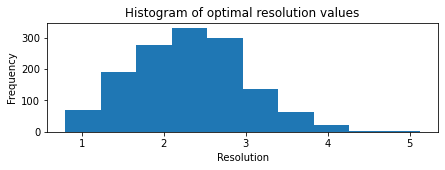

In [74]:
res_vals = Counter()
with open(LOGS + 'word_clusters_eval/resolution_optimal.log', 'r') as infile: 
    for line in infile: 
        contents = line.strip().split(' ')
        res_vals[contents[0]] = float(contents[2])
plt.rcParams["figure.figsize"] = (7,2)
plt.hist(list(res_vals.values()))
plt.ylabel("Frequency")
plt.xlabel("Resolution")
plt.title("Histogram of optimal resolution values")
plt.show()